# Evaluation Assignment 4

## Required Libraries

In [72]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
import math
from sklearn.metrics import accuracy_score
from graphviz import Digraph

## Dataset Creation

Dataset:
    symptom_1  symptom_2  symptom_3  symptom_4     disease
0           0          1          0          0      Asthma
1           0          1          0          0   Pneumonia
2           0          1          0          0     Allergy
3           0          0          1          0  Bronchitis
4           1          1          1          0         Flu
5           1          0          1          1      Asthma
6           1          1          1          1        Cold
7           1          1          0          0      Asthma
8           1          1          1          0        Cold
9           1          0          0          0  Bronchitis
10          0          0          1          1  Bronchitis
11          1          1          1          0  Bronchitis
12          1          1          0          1        Cold
13          0          1          0          1      Asthma
14          1          0          0          0  Bronchitis
15          0          0          0          0 

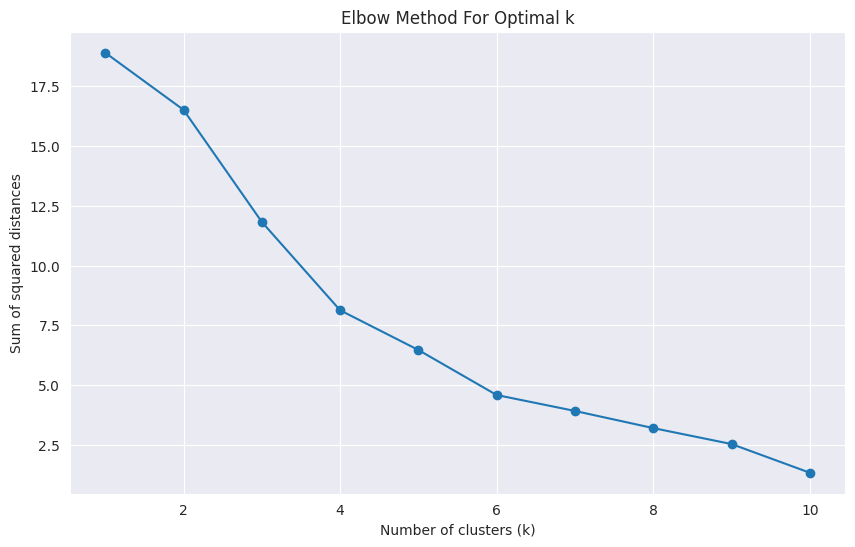

In [73]:
# Parameters for dataset generation
num_records = 20  
num_diseases = 6   
num_symptoms = 4   


np.random.seed(42)  
symptom_data = np.random.randint(0, 2, size=(num_records, num_symptoms))
symptom_columns = [f"symptom_{i+1}" for i in range(num_symptoms)]


diseases = ["Flu", "Cold", "Allergy", "Asthma", "Pneumonia", "Bronchitis"]
disease_data = np.random.choice(diseases, num_records)

df = pd.DataFrame(symptom_data, columns=symptom_columns)
df['disease'] = disease_data

# Display the dataset
print("Dataset:")
print(df)

# Implementing the Elbow Method
X = df[symptom_columns].values
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## (a) K-Nearest Neighbors (k-NN) Algorithm

In [74]:
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1) - 1):  # exclude the label column
        distance += (row1[i] - row2[i]) ** 2
    return math.sqrt(distance)


def knn_predict(train, test_row, num_neighbors):
    distances = []
    for index, train_row in train.iterrows():
        dist = euclidean_distance(test_row[:-1], train_row[:-1])
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = [distances[i][0] for i in range(num_neighbors)]
    output_values = [row['disease'] for row in neighbors]
    prediction = Counter(output_values).most_common(1)[0][0]
    return neighbors, prediction

## (b) Decision Tree Algorithm

In [75]:
def entropy(labels):
    label_counts = Counter(labels)
    total_count = len(labels)
    return -sum((count/total_count) * math.log2(count/total_count) for count in label_counts.values())

def info_gain(data, feature, label="disease"):
    total_entropy = entropy(data[label])
    values = data[feature].unique()
    weighted_entropy = 0
    for val in values:
        subset = data[data[feature] == val]
        weighted_entropy += (len(subset) / len(data)) * entropy(subset[label])
    return total_entropy - weighted_entropy

class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, label=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.label = label

def build_tree(data, features, label="disease"):
    if len(data[label].unique()) == 1:
        return DecisionTreeNode(label=data[label].iloc[0])
    if not features:
        return DecisionTreeNode(label=data[label].mode()[0])
    best_feature = max(features, key=lambda f: info_gain(data, f))
    root = DecisionTreeNode(feature=best_feature)
    remaining_features = [f for f in features if f != best_feature]
    left_split = data[data[best_feature] == 0]
    right_split = data[data[best_feature] == 1]
    if left_split.empty:
        root.left = DecisionTreeNode(label=data[label].mode()[0])
    else:
        root.left = build_tree(left_split, remaining_features, label)
    if right_split.empty:
        root.right = DecisionTreeNode(label=data[label].mode()[0])
    else:
        root.right = build_tree(right_split, remaining_features, label)
    return root

def predict_tree(node, row):
    if node.label is not None:
        return node.label
    if row[node.feature] == 0:
        return predict_tree(node.left, row)
    else:
        return predict_tree(node.right, row)

## Testing the Algorithms

In [76]:
test_case_dict = {"symptom_1": 1, "symptom_2": 1, "symptom_3": 0, "symptom_4": 1}
test_case_list = [test_case_dict[f"symptom_{i+1}"] for i in range(num_symptoms)] + [None]

neighbors, knn_prediction = knn_predict(df, test_case_list, num_neighbors=3)
print("k-NN Similar Cases and Prediction:")
for neighbor in neighbors:
    print(neighbor)
print("k-NN Prediction:", knn_prediction)

features = symptom_columns
decision_tree = build_tree(df, features)
test_case_series = pd.Series(test_case_dict)
dt_prediction = predict_tree(decision_tree, test_case_series)
print("Decision Tree Prediction:", dt_prediction)

k-NN Similar Cases and Prediction:
symptom_1         1
symptom_2         1
symptom_3         0
symptom_4         0
disease      Asthma
Name: 7, dtype: object
symptom_1       1
symptom_2       1
symptom_3       0
symptom_4       1
disease      Cold
Name: 12, dtype: object
symptom_1       1
symptom_2       1
symptom_3       0
symptom_4       1
disease      Cold
Name: 19, dtype: object
k-NN Prediction: Cold
Decision Tree Prediction: Cold


/tmp/ipykernel_5499/3506185363.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distance += (row1[i] - row2[i]) ** 2


## Accuracy , Visualization & Underfitting-Overfitting Analysis

In [77]:
train_df = df.sample(frac=0.7, random_state=42)
test_df = df.drop(train_df.index)

y_true = test_df["disease"]
y_pred = test_df.apply(lambda row: predict_tree(decision_tree, row), axis=1)

accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", accuracy)

# Analyze Overfitting/Underfitting
train_pred = train_df.apply(lambda row: predict_tree(decision_tree, row), axis=1)
train_accuracy = accuracy_score(train_df["disease"], train_pred)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", accuracy)
if train_accuracy > accuracy:
    print("The model is likely overfitting as the training accuracy is higher than test accuracy.")
else:
    print("The model may be underfitting or is well-generalized depending on test accuracy.")

# Decision Tree Visualization
def visualize_tree(node, graph=None, parent=None, label=None):
    if graph is None:
        graph = Digraph()
        graph.node(name=str(node), label=node.feature if node.feature else node.label)
    if node.left:
        graph.node(name=str(node.left), label=node.left.feature if node.left.feature else node.left.label)
        graph.edge(str(node), str(node.left), label='0')
        visualize_tree(node.left, graph, node, '0')
    if node.right:
        graph.node(name=str(node.right), label=node.right.feature if node.right.feature else node.right.label)
        graph.edge(str(node), str(node.right), label='1')
        visualize_tree(node.right, graph, node, '1')
    return graph

graph = visualize_tree(decision_tree)
graph.render('decision_tree', format='png')

import os
from PIL import Image

image_path = 'decision_tree.png'
if os.path.exists(image_path):
    img = Image.open(image_path)
    img.show()

Test Accuracy: 0.8333333333333334
Training Accuracy: 0.7857142857142857
Test Accuracy: 0.8333333333333334
The model may be underfitting or is well-generalized depending on test accuracy.
